#Imports

In [ ]:

from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, RidgeCV
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, scale
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

import itertools
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import platform
import math
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

#Linear Regression using sklearn

**Train and evaluate a least squares linear regression model predicting the value of
variable D from variables A, B and C**

In [ ]:
df = pd.read_csv("data.csv")
df = shuffle(df, random_state=42)
lin_reg = LinearRegression()


X = df[['A', 'B', 'C']]
y = df[['D']]
train_size = int(0.75 * X.shape[0])
X_train = X[:-train_size]
y_train = y[:-train_size]

X_test = X[-train_size:]
y_test = y[-train_size:]

lin_reg.fit(X_train,y_train)

print('Coefficient of determination: %f'
      % lin_reg.score(X_test, y_test))

Coefficient of determination: 0.883044


**Repeat the above task after carrying out in turn data normalisation, data scaling and
their combination, and evaluate the benefits of each of these 3 types of data preprocessing**

Normalise:

In [ ]:
norm_reg = LinearRegression()

Xn = normalize(X)

X_train = Xn[:-train_size]
X_test = Xn[-train_size:]

norm_reg.fit(X_train,y_train)

print('Coefficient of determination: %f'
      % norm_reg.score(X_test, y_test))

Coefficient of determination: 0.915652


Scale:

In [ ]:
scale_reg = LinearRegression()

Xs = scale(X)
Xs = pd.DataFrame(Xs)
X_train = Xs[:-train_size]

X_test = Xs[-train_size:]

scale_reg.fit(X_train,y_train)

print('Coefficient of determination: %f'
      % scale_reg.score(X_test, y_test))


Coefficient of determination: 0.882137


Scale and Normalise:

In [ ]:
sn_reg = LinearRegression()

Xsn = scale(normalize(X))
X_train = Xsn[:-train_size]
X_test = Xsn[-train_size:]

sn_reg.fit(X_train,y_train)

print('Coefficient of determination: %f'
      % sn_reg.score(X_test, y_test))


Coefficient of determination: 0.915579


For Linear Regression, it appears Scaling the data does not have much of an affect on the R<sup>2</sup> score for (in fact makes it slightly worse). The Normalisation does improve it by a decent amount, and doing both Normalisation and Scaling only improves it by roughly as much as Normalisation by itself does.

**Try to outperform the best result of the previous step by using regularisation (e.g. L1,
L2 or Elastic Net). Evaluate the benefits of
regularisation.**

In [ ]:
estimators = [LassoCV(max_iter=10000), ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], max_iter=10000), RidgeCV()]
scores = []

input_versions = [X.values, normalize(X), scale(X), scale(normalize(X))]
input_as_string = ["Un-preprocessed", "Normalised", "Scaled", "Scaled and Normalised"]
estimators_as_string = ["Lasso", "ElasticNet", "Ridge"]

for i, regularised_reg in enumerate(estimators):
  for j, input in enumerate(input_versions):
      X_train = input[:-train_size]
      X_test = input[-train_size:]

      regularised_reg.fit(X_train.squeeze(),y_train.squeeze())
      score = regularised_reg.score(X_test,y_test)
      scores.append((i, j, score))
      print("{} on {} data: {}".format(estimators_as_string[i], input_as_string[j], score))
i, j, best_score = max(scores, key=lambda a : a[2])
best_reg = estimators[i]
print("Best estimator is {} on {} input with score {}".format(best_reg, input_as_string[j], best_score))

Lasso on Un-preprocessed data: 0.8863235878371559
Lasso on Normalised data: 0.9151817644896547
Lasso on Scaled data: 0.8863235878371559
Lasso on Scaled and Normalised data: 0.9155967972623178
ElasticNet on Un-preprocessed data: 0.886339620940986
ElasticNet on Normalised data: 0.9135645025947073
ElasticNet on Scaled data: 0.8863995504283291
ElasticNet on Scaled and Normalised data: 0.9157429588968155
Ridge on Un-preprocessed data: 0.8823274722823946
Ridge on Normalised data: 0.8826503674749708
Ridge on Scaled data: 0.882422580044977
Ridge on Scaled and Normalised data: 0.9159509045214972
Best estimator is RidgeCV() on Scaled and Normalised input with score 0.9159509045214972


The hyperparamters are chosen via cross-validation (Leave-One-Out in this case).

Regularisation marginally improves the score for this dataset, by ~0.03% with Ridge (L2)
having the greatest improvement on the Scaled and Normalised input, which previously did not have an effect on the Linear Regression.

**Add a complete set of second-order polynomial basis functions to the original data
and train a linear regression with an appropriate type of regularisation to find out whether the
new basis functions bring any benefits.**

In [ ]:
poly_estimators = [make_pipeline(PolynomialFeatures(degree=2), e) for e in estimators]
scores = []
for i, poly_reg in enumerate(poly_estimators):
    X_train = X[:-train_size]
    X_test = X[-train_size:]

    poly_reg.fit(X_train.squeeze(),y_train.squeeze())
    scores.append((i, poly_reg.score(X_test,y_test)))
i, best_score = max(scores, key=lambda a : a[1])
best_reg = poly_estimators[i]
print("Best estimator is {} with score {}".format(best_reg, best_score))

Best estimator is Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('lassocv', LassoCV(max_iter=10000))]) with score 0.907067235875337


*Assumption: "original data" means un-preprocessed inputs (no normalisation, scaling)*

Comparing this with Lasso on original data above, the basis functions give an improvement of 2%. This tells us that a degree-2 polynomial fits the data more accurately than a straight line.



**Implement an appropriate automated procedure that will train all of the above models
and select the model expected to perform best on unseen data with the same distribution as the
training data.**

In [ ]:
def trainModels(filename):
  df = pd.read_csv(filename)
  df = shuffle(df, random_state=42)

  X = df[['A', 'B', 'C']]
  y = df[['D']]

  train_size = int(0.75 * X.shape[0])

  y_train = y[:-train_size]
  y_test = y[-train_size:]

  input_versions = [X.values, normalize(X), scale(X), scale(normalize(X))]
  input_as_string = ["Un-preprocessed", "Normalised", "Scaled", "Scaled and Normalised"]
  estimators = [LinearRegression(), LassoCV(max_iter=10000), ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], max_iter=10000), RidgeCV()]
  estimators.extend([make_pipeline(PolynomialFeatures(degree=2), e) for e in estimators])

  scores = []
  # Get list of scores for each model and for each input type
  for i, estimator in enumerate(estimators):
    for j, input in enumerate(input_versions):
      X_train = input[:-train_size]
      X_test = input[-train_size:]

      estimator.fit(X_train.squeeze(),y_train.squeeze())
      scores.append((i, j, estimator.score(X_test,y_test)))

  i, j, best_score = max(scores, key=lambda a : a[2])
  print("Best r_2 score : {}".format(best_score))

  X_train = input_versions[j][:-train_size]
  X_test = input_versions[j][-train_size:]

  best_reg = estimators[i]
  best_reg.fit(X_train.squeeze(), y_train.squeeze())

  print("Best estimator is {} on {} input".format(best_reg, input_as_string[j]))

  return best_reg

reg = trainModels("unseendata.csv")

Best r_2 score : 0.9228581150295795
Best estimator is Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridgecv', RidgeCV())]) on Scaled and Normalised input


The above function takes as input the filename to the unseen data, splits the data into training and test sets, then fits each model to the data and returns the one with the best score.

**Starting with the data in data.csv, find the median value of variable D. Replace all
values up to and including the median value with 0, and all values greater than that with 1. Treat
the resulting values of D as class labels to train and evaluate a classifier based on logistic
regression that takes variables A, B and C as input.**

In [ ]:
df = pd.read_csv("data.csv")
df = shuffle(df, random_state=42)

median_val = df.median()['D']
# Replace values with 0 or 1 if higher or lower than median of D
df.loc[df['D'] <= median_val, 'D'] = 0
df.loc[df['D'] > median_val, 'D'] = 1

X = df[['A','B','C']]
y = df[['D']]

X_train = X[:-train_size]
y_train = y[:-train_size]

X_test = X[-train_size:]
y_test = y[-train_size:]

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train.squeeze(),y_train.squeeze())

print('Coefficient of determination: %f'
      % logistic_reg.score(X_test, y_test))

Coefficient of determination: 0.901408


#Principal Component Analysis with sklearn

In [ ]:
X = pd.read_csv("data.csv")
combinations = itertools.combinations(X.columns, 2)
# Extend table
for item in combinations:
  X[item[0]+item[1]] = X[item[0]] * X[item[1]]

# Fit PCA
pca = PCA(n_components=4)
pca.fit(X)

components = pd.DataFrame(pca.components_.T, index=X.columns, columns=['PC1','PC2','PC3','PC4'])
print("PCs from 10 inputs")
print(components)
print('\nVariance per component:\n{}\n'.format(list(zip(components.columns, pca.explained_variance_))))

print("Inputs with strongest effect:")
print(pd.DataFrame([components.abs().idxmax(), components.abs().max()], index=['Variable', 'Value']))

PCs from 10 inputs
         PC1       PC2       PC3       PC4
A   0.020967  0.027234  0.126361  0.064581
B   0.033217  0.043145  0.200190  0.102314
C   0.023794  0.030905  0.143398  0.073289
D   0.009679  0.068156  0.043797 -0.117578
AB  0.583179 -0.179090  0.229728  0.029764
AC  0.267797 -0.323043 -0.739102 -0.440525
AD  0.139362  0.124417 -0.327034  0.542172
BC  0.663484 -0.201064  0.270788  0.038932
BD  0.318096  0.882351 -0.077775 -0.323179
CD  0.158640  0.144626 -0.368921  0.609350

Variance per component:
[('PC1', 21115.0432857451), ('PC2', 81.25477909560729), ('PC3', 10.62028533588803), ('PC4', 0.858144337749792)]

Inputs with strongest effect:
               PC1       PC2       PC3      PC4
Variable        BC        BD        AC       CD
Value     0.663484  0.882351  0.739102  0.60935


Each of the four inputs that most strongly affect the components are the extended product inputs. This makes sense as a product of two inputs is naturally going to contain larger values, which means its influence on the variance is larger.

Input B appears in the product with the strongest effect for PC1 and PC2, which would suggest it has a significant impact on the variance of the data:

In [ ]:
X.mean()

A       5.395095
B      18.601274
C       6.172905
D       4.160568
AB    115.272264
AC     43.988371
AD     26.887332
BC    131.751761
BD     84.427092
CD     30.722208
dtype: float64

The mean for input B is significantly larger than the other original inputs, which supports the above finding.

#Architect and train classifier of tree symbols

Assuming data is available as "symbols_dataset.zip",  unzip and remove MacOS Finder files

In [ ]:
!unzip -nq symbols_dataset.zip
!rm -rf __MACOSX
!find . -name ".DS_Store" -type f -delete

Create Custom Dataset, loading images after the dataset is indexed, instead of all at once

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, class_folders, transform=transforms.Compose([transforms.Grayscale(),transforms.ToTensor(),transforms.Normalize(0.5,0.5)])):
    self.class_folders = class_folders
    self.transform = transform
    self.image_paths = []
    self.labels = []

    for dirname in self.class_folders:
      for basename in os.listdir(dirname):
        self.image_paths.append(os.path.join(dirname,basename))
        self.labels.append(int(dirname[-1]))

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    assert idx >= 0
    assert idx < len(self)

    image = self.transform(Image.open(self.image_paths[idx]))
    label = self.labels[idx]
    return image, label

List of transforms for data augmentation. Since there aren't that many images in certain classes, this should help introduce "new" images to train on.

In [ ]:
data_aug=transforms.Compose([
  transforms.Grayscale(),
  transforms.RandomRotation(50,expand=True,fill=1.),
  transforms.Resize((48,48)),
  transforms.RandomHorizontalFlip(0.4),
  transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),
  transforms.ToTensor(),
  transforms.Normalize(0.5,0.5)
])

Split data into train and test sets and shuffle data, with test size of 1/3. Use of Subsets is to avoid any data augmentation for the test set.

In [ ]:
class_dirnames = ['class_0','class_1','class_2','class_3','class_4']

train_data = CustomDataset(class_dirnames, transform=data_aug)
test_data = CustomDataset(class_dirnames)

indices = list(range(len(train_data)))

train_indices, test_indices = train_test_split(indices, test_size=0.33)
train_data = torch.utils.data.Subset(train_data, train_indices)
test_data  = torch.utils.data.Subset(test_data, test_indices)

print("len of Training: ", len(train_data))
print("len of Testing: ", len(test_data))

len of Training:  11274
len of Testing:  5554


Create dataloaders using datasets above and batch_size of 100.

In [ ]:
batch_size=100

if 'microsoft-standard' in platform.uname().release: # Windows can't use fork() properly so num_workers has to be 0
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
else:
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

Archicture inspired by VGG as a simplified version is easy to achieve in fewer layers. Also include BatchNorms to help avoid overfitting and remove the need for dropout. Using ReLU as the activation function avoids the vanishing gradient problem.

Residual blocks were considered, however their benefit is most prominent in much deeper networks than this problem requires.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(24),
            nn.ReLU()
        )

        self.MLP = nn.Sequential(
            nn.Linear(in_features=10*10*24,out_features=100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84,out_features=5)
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.MLP(x)
        return x


model = CNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

Cross Entropy Loss is chosen as the loss function as it allows us to classify the output into one of the 5 classes. It also has capacity for class weights which lets us deal with the class imbalance by penalising misclassifying as more frequently occuring classes, and rewarding correctly classifying rare classes, without the need for something like WeightedRandomSampler.

In [ ]:
_, y_train = zip(*train_data)
class_weights = compute_class_weight('balanced', classes=list(set(y_train)), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
loss_func = nn.CrossEntropyLoss(weight=class_weights)

Test to make sure everything looks okay so far

torch.Size([100, 5])
tensor(1.6847, device='cuda:0', grad_fn=<NllLossBackward0>)


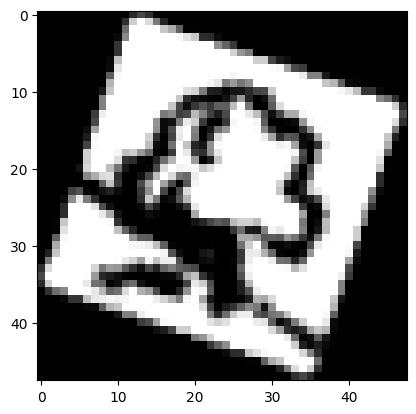

In [ ]:
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
output = model(images)
print(output.shape)
loss = loss_func(output,labels)
print(loss)
plt.imshow(images[0].cpu().squeeze(), cmap='gray')

Run training and evaluate

In [ ]:
num_epochs = 30

# Set up the optimiser
optim = torch.optim.Adam(model.parameters(), lr = 0.1)

# Initialise some variables for computing and tracking stats
iterations_per_epoch = math.ceil(len(train_data)/batch_size)
training_losses = []
training_accuracies = []
testing_losses = []
testing_accuracies = []
for epoch in range(num_epochs):

  # One epoch on the training set
  total_loss = 0
  correct = 0
  total = 0
  total_loss = 0
  for i, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    output = model(inputs)
    loss = loss_func(output,labels)
    optim.zero_grad()
    loss.backward()
    optim.step()
    pred_y = torch.argmax(output, 1)
    correct += (pred_y == labels).sum()
    total += float(labels.size(0))
    total_loss += loss*images.shape[0]
    if (i+1) % 100 == 0:
       print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
  total_loss /= len(train_data)
  training_losses.append(total_loss.item())
  training_accuracies.append(correct/total)
  print('Train accuracy over epoch {}: {:.4f}'.format(epoch+1,training_accuracies[-1]))

  # One epoch on the test set
  correct = 0
  total = 0
  y_true = []
  y_pred = []
  # Switch to evaluation mode
  model.eval()
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      output = model(inputs)
      loss = loss_func(output,labels)
      pred_y = torch.argmax(output, 1)
      correct += (pred_y == labels).sum()
      total += float(labels.size(0))
      total_loss += loss*images.shape[0]
      if(epoch==num_epochs-1):
        y_true.extend(labels.cpu())
        y_pred.extend(pred_y.cpu())
    test_accuracy = correct/total
  total_loss /= len(test_data)
  testing_losses.append(total_loss.item())
  # Switch back to training mode
  model.train()
  testing_accuracies.append(test_accuracy)
  print('Test accuracy at epoch {}: {:.4f}'.format(epoch+1,test_accuracy))

Epoch [1/30], Iteration [100/113], Loss: 0.0824
Train accuracy over epoch 1: 0.8345
Test accuracy at epoch 1: 0.9462
Epoch [2/30], Iteration [100/113], Loss: 0.3920
Train accuracy over epoch 2: 0.9304
Test accuracy at epoch 2: 0.9508
Epoch [3/30], Iteration [100/113], Loss: 0.0256
Train accuracy over epoch 3: 0.9634
Test accuracy at epoch 3: 0.9779
Epoch [4/30], Iteration [100/113], Loss: 0.0437
Train accuracy over epoch 4: 0.9689
Test accuracy at epoch 4: 0.9638
Epoch [5/30], Iteration [100/113], Loss: 0.0378
Train accuracy over epoch 5: 0.9635
Test accuracy at epoch 5: 0.9633
Epoch [6/30], Iteration [100/113], Loss: 0.4740
Train accuracy over epoch 6: 0.9727
Test accuracy at epoch 6: 0.9759
Epoch [7/30], Iteration [100/113], Loss: 0.0378
Train accuracy over epoch 7: 0.9582
Test accuracy at epoch 7: 0.9615
Epoch [8/30], Iteration [100/113], Loss: 0.1895
Train accuracy over epoch 8: 0.9702
Test accuracy at epoch 8: 0.9656
Epoch [9/30], Iteration [100/113], Loss: 0.0234
Train accuracy o

Save weights

In [ ]:
torch.save(model.state_dict(), 'weights.pkl')

Check per-class accuracy to see if the class imbalance has affected it

In [ ]:
cm = confusion_matrix(y_true,y_pred, labels =[0,1,2,3,4])
print('class 0 accuracy: {0:.3f}'.format(cm[0,0]/sum(cm[0])))
print('class 1 accuracy: {0:.3f}'.format(cm[1,1]/sum(cm[1])))
print('class 2 accuracy: {0:.3f}'.format(cm[2,2]/sum(cm[2])))
print('class 3 accuracy: {0:.3f}'.format(cm[3,3]/sum(cm[3])))
print('class 4 accuracy: {0:.3f}'.format(cm[4,4]/sum(cm[4])))

class 0 accuracy: 0.987
class 1 accuracy: 1.000
class 2 accuracy: 1.000
class 3 accuracy: 0.995
class 4 accuracy: 0.976


Seems good!

Test classify_symbols function just to be sure:

In [ ]:
import classify_symbols

images, labels = next(iter(test_loader))
output = classify_symbols.classify(images)
correct = 0
for i in range(len(output)):
  if output[i] == labels[i]:
    correct += 1

correct / len(output)

1.0

#Architect and train GAN to generate tree symbols

Specify GAN parameters.



In [ ]:
batch_size = 100
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 100 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

Setup dataset and dataloader

Addressing the class imbalance - to prevent mode collapse, oversample the rare classes using WeightedRandomSampler, since we cannot give these weights are not applicable to the loss function like with Q3.

In [ ]:
transform = transforms.Compose([transforms.Grayscale(),transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),  transforms.Normalize(0.5,0.5)])
gan_data = CustomDataset(['class_1','class_2','class_3','class_4'], transform=transform)

y_data = gan_data.labels
# Compute class weights
class_weights = compute_class_weight('balanced', classes=list(set(y_data)), y=y_data)
class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
# Compute weights for each sample from class weights
samples_weight = [class_weights[t-1] for t in y_data]
samples_weight = torch.tensor(samples_weight)

sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))
dataloader = torch.utils.data.DataLoader(gan_data, batch_size=batch_size, sampler=sampler, drop_last=True)

Make sure images have loaded correctly:

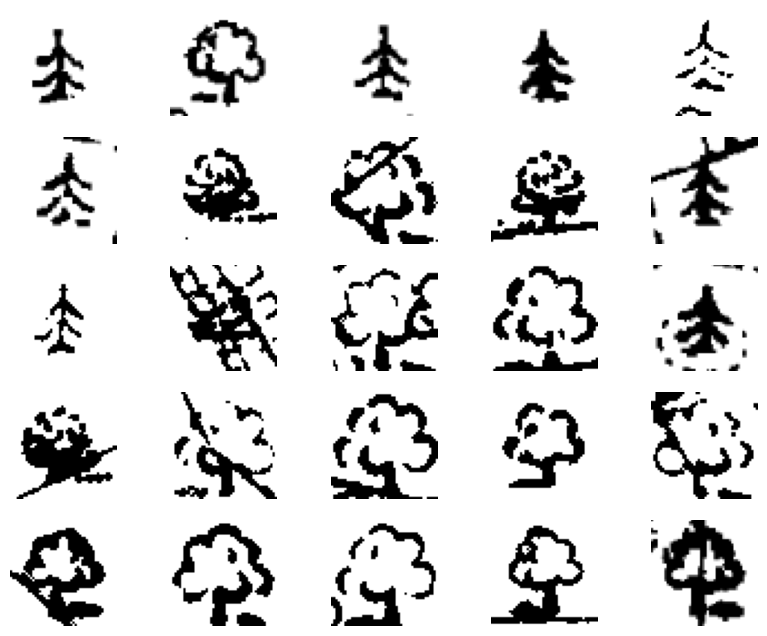

In [ ]:
images, labels = next(iter(dataloader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(images[i,:].squeeze(), cmap="gray")
plt.show()

Architecture inspired by DCGAN:
- Strided convlotuions instead of maxpooling so GAN can learn its own upsampling/downsampling
- BatchNorm to help avoid modal collapse
- Empirically choose ReLU as activation function for Generator
- LeakyReLU required due to dying ReLU problem, since gradients are passed back and forth between Generator and Discriminator

The following modifications were made to DCGAN:
- Hyperparameters adjusted to accomodate 48x48 image size
- Sigmoid removed from last layer of Discriminator, in favour of BCEWithLogitsLoss, which combines BCE and Sigmoid but is more numerically stable (log-sum-exp)
- Noise added to Discriminator input to elicit better generalisation and avoid the Disciminator Loss dropping to 0 immediately.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z of size B x nz x 1 x 1, we put this directly into a transposed convolution
            nn.ConvTranspose2d( nz, ngf * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(),
            # Size: B x (ngf*8) x 3 x 3
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(),
            # Size: B x (ngf*4) x 6 x 6
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(),
            # Size: B x (ngf*2) x 12 x 12
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
            # Size: B x (ngf) x 24 x 24
            nn.ConvTranspose2d( ngf, 1, 4, 2, 1, bias=False),
            # Size: B x 1 x 48 x 48
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

netG = Generator()
netG = netG.to(device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Size: B x 1 x 48 x 48
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: B x (ndf) x 24 x 24
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: B x (ndf*2) x 12 x 12
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: B x (ndf*4) x 6 x 6
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: B x (ndf*8) x 3 x 3
            nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False)
        )

    def forward(self, input):
        input = torch.randn_like(input) + input
        return self.main(input)

netD = Discriminator()
netD = netD.to(device)

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(

Run training loop

In [ ]:
criterion = nn.BCEWithLogitsLoss()

real_label = 1.
fake_label = 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images,labels) in enumerate(dataloader, 0):

        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Real batch
        netD.zero_grad()
        real_images = images.to(device)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Fake batch
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(z)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

[1/100][0/108]	Loss_D: 1.7815	Loss_G: 1.2592	D(x): 0.1332	D(G(z)): 0.5541 / -0.8149
[1/100][50/108]	Loss_D: 0.3185	Loss_G: 4.6622	D(x): 3.6030	D(G(z)): -2.1422 / -4.6444
[1/100][100/108]	Loss_D: 0.3302	Loss_G: 7.8148	D(x): 2.7528	D(G(z)): -7.5368 / -7.8137
[2/100][0/108]	Loss_D: 0.2017	Loss_G: 6.1219	D(x): 5.8809	D(G(z)): -3.0105 / -6.1166
[2/100][50/108]	Loss_D: 0.1759	Loss_G: 5.0839	D(x): 4.2345	D(G(z)): -4.7201 / -5.0489
[2/100][100/108]	Loss_D: 0.3517	Loss_G: 6.4354	D(x): 3.6514	D(G(z)): -3.0774 / -6.4195
[3/100][0/108]	Loss_D: 0.3068	Loss_G: 6.9738	D(x): 4.8402	D(G(z)): -3.1625 / -6.9664
[3/100][50/108]	Loss_D: 0.8181	Loss_G: 4.4141	D(x): 1.7475	D(G(z)): -1.2891 / -4.3777
[3/100][100/108]	Loss_D: 0.7824	Loss_G: 2.5517	D(x): 0.7328	D(G(z)): -4.0758 / -2.3511
[4/100][0/108]	Loss_D: 0.6640	Loss_G: 3.0327	D(x): 1.1076	D(G(z)): -3.8233 / -2.8880
[4/100][50/108]	Loss_D: 0.4333	Loss_G: 3.9778	D(x): 2.4870	D(G(z)): -2.4820 / -3.9229
[4/100][100/108]	Loss_D: 0.6779	Loss_G: 3.0151	D(x): 1.9

Plot 8 random images

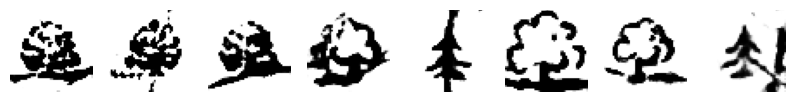

In [ ]:
z = torch.randn(8,nz,1,1,device=device)
images = netG(z)

figure = plt.figure(figsize=(10, 8))
cols, rows = 8, 1
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(images[i,:][0].cpu().detach().squeeze(), cmap="gray")
plt.show()

Interpolate between two images using [Spherical Interpolation](https://arxiv.org/pdf/1609.04468.pdf) instead of linearly due to Gaussian Sampling being spherical.

In [ ]:
def slerp(val, low, high):
    low_norm = low/torch.norm(low, dim=1, keepdim=True)
    high_norm = high/torch.norm(high, dim=1, keepdim=True)
    omega = torch.acos((low_norm*high_norm).sum(1))
    so = torch.sin(omega)
    res = (torch.sin((1.0-val)*omega)/so).unsqueeze(1)*low + (torch.sin(val*omega)/so).unsqueeze(1) * high
    return res

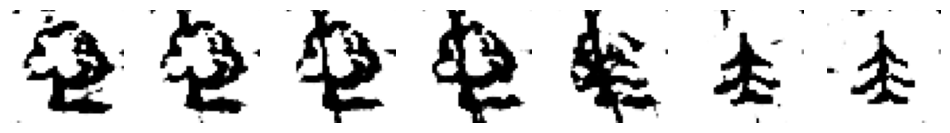

In [ ]:
nsamples = 7

z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
z = torch.zeros(nsamples,nz,1,1,device=device)

for i in range(nsamples):
  w = i/(nsamples-1)
  z[i,:,:,:] = slerp(w,z1,z2)
images = netG(z)

figure = plt.figure(figsize=(12, 4))
for i in range(nsamples):
    figure.add_subplot(1, nsamples, i+1)
    plt.axis("off")
    plt.imshow(images[i,:].squeeze().cpu().detach(), cmap="gray")
plt.show()